<a href="https://colab.research.google.com/github/ander-yamamoto/dio-bairesdev/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with Python

Based on tranfer learning tutorial in:  
https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb

In [1]:
# =========================================
# 1. Imports e Configurações
# =========================================
%matplotlib inline

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Dense
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

!pip install simple-image-download tqdm

from simple_image_download import simple_image_download as simp
from tqdm import tqdm
import requests

INFO: pip is looking at multiple versions of simple-image-download to determine which version is compatible with other requirements. This could take a while.


In [2]:
# =========================================
# 2. Função para baixar imagens
# =========================================
def download_with_progress(query, num_images):
    downloader = simp.simple_image_download()
    links = downloader.urls(query, num_images)  # pega URLs sem baixar ainda

    save_dir = os.path.join("simple_images", query)
    os.makedirs(save_dir, exist_ok=True)

    for url in tqdm(links, desc=f"Baixando {query}"):
        try:
            img_data = requests.get(url, timeout=5).content
            file_name = os.path.join(save_dir, os.path.basename(url.split("?")[0]))
            with open(file_name, "wb") as f:
                f.write(img_data)
        except:
            pass  # ignora erros

In [3]:
# =========================================
# 3. Baixar Dataset
# =========================================

cat1 = "Bulbassaur"
cat2 = "Charmander"

if not os.path.exists(os.path.join('simple_images', cat1)):
    download_with_progress(cat1, 300)
else:
    print(f"Banco de imagens de {cat1} já existe. Pulando download.")

if not os.path.exists(os.path.join('simple_images', cat2)):
    download_with_progress(cat2, 300)
else:
    print(f"Banco de imagens de {cat2} já existe. Pulando download.")

# Listar categorias existentes
root = 'simple_images'
categories = [
    os.path.join(root, c)
    for c in os.listdir(root)
    if os.path.isdir(os.path.join(root, c))
]
print("Categorias:", categories)

Baixando Charmander: 100%|██████████| 300/300 [01:28<00:00,  3.40it/s]

Categorias: ['simple_images/Bulbassaur', 'simple_images/Charmander']


In [4]:
# =========================================
# 4. Função para carregar imagens
# =========================================
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    return img, x


In [5]:
# =========================================
# 5. Montar dataset com limite por classe
# =========================================
data = []
max_images_per_class = 250

for c, category in enumerate(categories):
    images = [
        os.path.join(dp, f)
        for dp, dn, filenames in os.walk(category)
        for f in filenames
        if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']
    ]
    random.shuffle(images)
    for i, img_path in enumerate(images[:max_images_per_class]):
        try:
            img, x = get_image(img_path)
            data.append({'x': x, 'y': c})
        except:
            pass

random.shuffle(data)
num_classes = len(categories)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
# =========================================
# 6. Separar treino / validação / teste
# =========================================
train_split, val_split = 0.7, 0.15
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))

train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")

Train: (88, 224, 224, 3), Val: (19, 224, 224, 3), Test: (20, 224, 224, 3)


In [7]:
# =========================================
# 7. Data Augmentation para treino
# =========================================
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train)

In [8]:
# =========================================
# 8. Carregar VGG16 pré-treinada
# =========================================
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)

# Trocar última camada
new_classification_layer = Dense(num_classes, activation='softmax')
out = new_classification_layer(vgg.layers[-2].output)
model_new = Model(inputs=vgg.input, outputs=out)

# Congelar todas as camadas menos a última
for layer in model_new.layers[:-1]:
    layer.trainable = False
model_new.layers[-1].trainable = True

# Compilar e treinar fase 1
model_new.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

history1 = model_new.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=10
)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 10s/step - accuracy: 0.5601 - loss: 1.1282 - val_accuracy: 0.5789 - val_loss: 0.9051
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - accuracy: 0.7437 - loss: 0.5016 - val_accuracy: 0.6316 - val_loss: 0.4965
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step - accuracy: 0.8920 - loss: 0.2825 - val_accuracy: 0.8421 - val_loss: 0.3538
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step - accuracy: 0.9171 - loss: 0.2289 - val_accuracy: 0.7368 - val_loss: 0.4217
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step - accuracy: 0.9426 - loss: 0.1217 - val_accuracy: 0.6842 - val_loss: 0.5400
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 573ms/step - accuracy: 0.9390 - loss: 0.1361 - val_accuracy: 0.7895 - val_loss: 0.3750
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 596ms/step - accuracy: 0.9738 - loss: 0.0791 - val_accuracy: 0.8421 - val_loss: 0.2922
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - accuracy: 0.9605 - loss: 0.0880 - val_accuracy: 0.8947 - val_loss: 

In [9]:
# =========================================
# 10. Avaliação final
# =========================================
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.06487567722797394
Test accuracy: 1.0


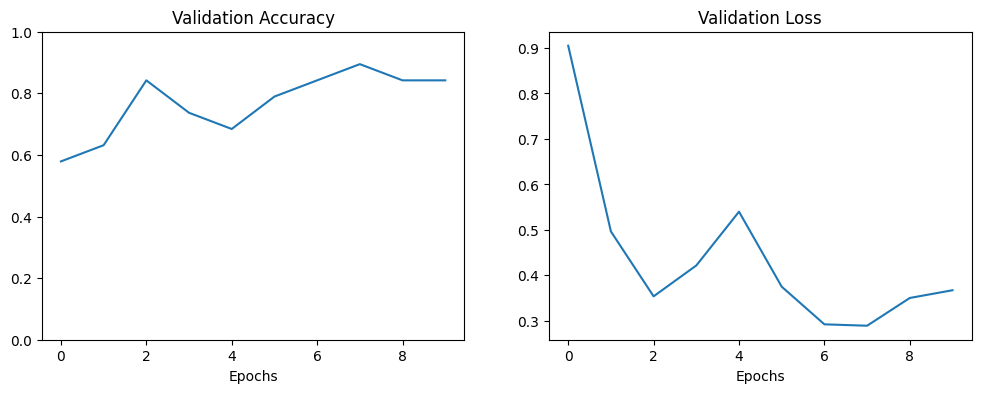

In [10]:
# =========================================
# 11. Plotar métricas
# =========================================
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history1.history['val_accuracy'])
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylim(0, 1)

plt.subplot(1,2,2)
plt.plot(history1.history['val_loss'])
plt.title("Validation Loss")
plt.xlabel("Epochs")

plt.show()